# Evaluate on Synthetic

In [3]:
import yaml
import json
import pickle
import os
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from matplotlib.patches import Patch


from fault_management_uds.plots import pca_plot
from fault_management_uds.config import get_additional_configurations
from fault_management_uds.utilities import seed_everything
from fault_management_uds.modelling.models import load_model_checkpoint
from fault_management_uds.data.dataset import load_data, get_sensor_dataset
from fault_management_uds.synthetic.synthetic_generator import AnomalyHandler, find_unterrupted_sequences


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta


from fault_management_uds.data.load import import_metadata


2025-01-02 15:02:27.126 | INFO     | fault_management_uds.config:<module>:15 - PROJ_ROOT path is: /work3/s194262/GitHub/fault_management_uds
2025-01-02 15:02:28.095846: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 15:02:28.179573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735826548.222223 2793508 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735826548.234915 2793508 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
20

In [2]:
metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
# load the sensor ranges
with open(REFERENCE_DIR / 'sensor_ranges.json', 'r') as f:
    sensor_ranges = json.load(f)

#### Steps:

- Inject anomalies into test data
- Predict
- Save an observations prediction error and target value

## Feature importance

## Load data and model

In [5]:
def load_data_and_model(experiment_folder, data_type, subset=None):
    save_folder = MODELS_DIR / experiment_folder

    split = 0 # first split
    relative_path = f'{split+1}_split/'
    run_folder = save_folder / relative_path
    print(save_folder)

    # load the config
    config = yaml.load(open(save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)
    print(f"Total runs: {config['dataset_args']['n_splits']}") 
    seed = config['training_args']['seed']
    seed_everything(seed)

    # run info for each split
    split_info = torch.load(save_folder / 'split_info.pkl', map_location='cpu')
    run_info = split_info[split]    
    # adjust the paths if needed
    if '/' in run_info['best_model_path']:
        run_info['best_model_path'] = os.path.relpath(run_info['best_model_path'], run_folder)
        run_info['last_model_path'] = os.path.relpath(run_info['last_model_path'], run_folder)
        run_info['top_k_best_model_paths'] = {
            k: os.path.relpath(str(v), run_folder) for k, v in run_info['top_k_best_model_paths'].items()
        }


    # load the data
    data_indices = run_info['dataset_config'][f'{data_type}_index']
    print(f"Data type: {data_type}, Data indices: {len(data_indices)}")
    
    # Subset if specified
    data_indices = data_indices if subset is None else data_indices[:subset]

    # load the data
    scalers = run_info['dataset_config']['scalers']
    data = load_data([None, None], config['dataset_args']['data_file_path'], config['dataset_args'], data_type='complete')

    # get a temporary dataset
    dataset = get_sensor_dataset(data, config['dataset_args'], 
        data_idx=data_indices, 
        scalers=scalers,
        priority_weight=None, verbose=False, dataset_type=data_type)

    # subset the data as well
    data = data.iloc[data_indices]

    # extract useful info
    additional_configurations = get_additional_configurations(dataset)

    # load the model
    model_to_load = config['training_args']['model_to_load']
    model = load_model_checkpoint(run_folder, run_info, model_to_load, config, additional_configurations)

    return config, run_folder, data, dataset, scalers, model


In [7]:
experiment_folder = 'transformer/0_results/6_final_selection'
data_type = 'val'
subset = 5000 # None

config, run_folder, data, dataset, scalers, model = load_data_and_model(experiment_folder, data_type, subset=subset)

# extract relevant info
sensor_name = config['dataset_args']['endogenous_vars'][0] # NOTE: only one sensor is supported
valid_indices = dataset.valid_indices
n_obs = dataset.n_obs
seed = config['training_args']['seed']

Seed set to 42


/work3/s194262/GitHub/fault_management_uds/models/transformer/0_results/6_final_selection
Total runs: 1
Data type: val, Data indices: 871758
Using CPU
Model loaded from /work3/s194262/GitHub/fault_management_uds/models/transformer/0_results/6_final_selection/1_split/epoch=07-val_loss=0.0000142.ckpt


In [8]:
# Extract more info
sensor_scale = sensor_ranges[sensor_name]['clean']['range']

sensor_meta = metadata[metadata['IdMeasurement'] == sensor_name]
unit = sensor_meta['UnitAlias'].values[0]
obvious_min = sensor_meta['obvious_min'].values[0]
obvious_max = sensor_meta['obvious_max'].values[0]  


## Inject anomalies and predict

In [10]:
# TODO:
# first get a model to train on the synthetic!

# so inject or get injected data
# get the predictions on it + relevant into
# function to get features from it

# visualize, pca and tnse

# but given a dataframe, a col_type_2_idx, and what col_types
# then fit anomaly detector on it
# evaluate its performance
# and other stuff
# adjust to the polluted types as well else good enough!

In [11]:
# load yaml file
with open(REFERENCE_DIR / 'synthetic_config.yaml', 'r') as f:
    synthetic_config = yaml.safe_load(f)

In [13]:
anomalies = list(synthetic_config['anomalies'].keys())
print(anomalies)    
severity = "medium"
# buffers are irrelevant
buffer = 2*60 # 12*60
edge_buffer = 24*60 # 7*24*60

# TODO: what about the sequence length and prediction ahead?

['spike', 'noise', 'frozen', 'offset', 'drift']


Inject anomalies

In [14]:
outputs_folder = run_folder / 'synthetic' / data_type
outputs_folder.mkdir(parents=True, exist_ok=True)

In [17]:
# convert form tensor to list
valid_indices = list(valid_indices)
indicators = np.zeros(n_obs)
polluted_data = data.copy()

anomaly_2_indicator = {}
for i, anomaly in enumerate(anomalies):
    print(f"Anomaly: {anomaly}")
    anomaly_config = synthetic_config['anomalies'][anomaly][severity]


    anomaly_handler = AnomalyHandler(anomaly_config, anomaly, config['dataset_args']['endogenous_vars'], n_obs, sensor_scale, obvious_min, obvious_max, 
                                     seed=seed, buffer=buffer, edge_buffer=edge_buffer, available_indices=valid_indices)

    # Inject anomalies
    anomaly_handler.initialize_injections()
    # on the polluted
    polluted_data = anomaly_handler.inject_anomalies(polluted_data)
    # get the indicator
    polluted_indicator = anomaly_handler.get_indicator()
    # set 1 (anomaly) values to i+1
    anomaly_2_indicator[anomaly] = i+1
    polluted_indicator = polluted_indicator * (anomaly_2_indicator[anomaly])
    # join the indicators; but keep the polluted indicator value
    indicators = np.maximum(indicators, polluted_indicator) # keep the highest value

    # Only keep indices that are not polluted
    valid_indices = [i for i in valid_indices if not indicators[i]] # remove the polluted indices if not 0
    print('')


print(f"Pollution proportion: {100*np.sum(indicators!=0)/n_obs:.2f}%")

# save as json
with open(outputs_folder / 'anomaly_2_indicator.json', 'w') as f:
    json.dump(anomaly_2_indicator, f)


Anomaly: spike
Total injections: 4
Last index is in available indices.

Anomaly: noise
Total injections: 2

Anomaly: frozen
Total injections: 2

Anomaly: offset
Total injections: 2

Anomaly: drift
Total injections: 2



In [18]:
print(f"Pollution proportion: {100*np.sum(indicators!=0)/n_obs:.2f}%")


Pollution proportion: 6.77%


In [23]:

def get_prediction_outputs(model, polluted_dataset, polluted_indicator, valid_indices, config):

    # Prepare columns for the results DataFrame
    column_2_idx = {column: [i] for i, column in enumerate(['starttime', 'valid_index', 'polluted', 'target'])}
    results = pd.DataFrame(index=range(len(valid_indices)), columns=column_2_idx.keys())
    # add the return columns          
    x, _, _, starttime = polluted_dataset[0]
    outputs = model.model.forward(x.unsqueeze(0))
    # add these to the results
    for output, return_name in zip(outputs, model.model.returns):
        return_dim = output.shape[1]
        n_columns = len(results.columns)
        idxs = [n_columns + i for i in range(return_dim)]
        column_2_idx[return_name] = idxs

        # remove the number if only one dim
        if return_dim == 1:
            column_2_idx[return_name] = idxs
            results[f'{return_name}'] = np.nan

        else:
            # add these to the results
            for i in range(return_dim):
                results[f'{return_name}_{i}'] = np.nan
            

    # Prepare DataLoader
    dataloader = DataLoader(
        polluted_dataset, 
        batch_size=config['training_args']['batch_size'], 
        shuffle=False, 
        num_workers=0
    )
    
    # Ensure valid_indices is a NumPy array
    valid_indices = np.array(valid_indices.cpu()) if torch.is_tensor(valid_indices) else np.array(valid_indices)
    
    # No gradient calculation during prediction
    with torch.no_grad():
        start = 0
        for batch in tqdm(dataloader, desc='Predicting'):
            x, y, _, starttime = batch
            batch_size = x.size(0)
            polluted = polluted_indicator[start:start+batch_size]
            
            # Forward pass
            outputs = model.model.forward(x)

            # Store the results
            results.iloc[start:start+batch_size, 0] = [pd.to_datetime(ts) for ts in starttime]
            results.iloc[start:start+batch_size, 1] = valid_indices[start:start+batch_size]
            results.iloc[start:start+batch_size, 2] = polluted
            results.iloc[start:start+batch_size, 3] = y.numpy()
            # add the output to the results
            for i, return_name in enumerate(model.model.returns):
                return_idxs = column_2_idx[return_name]
                output = outputs[i]
                results.iloc[start:start+batch_size, return_idxs] = output.numpy()

            # Update start index
            start += batch_size

    return results, column_2_idx

In [24]:

# create the dataset anew
polluted_dataset = get_sensor_dataset(polluted_data, config['dataset_args'], 
    #data_idx=data_indices, 
    scalers=scalers,
    priority_weight=None, verbose=False, dataset_type=data_type)

valid_indices = polluted_dataset.valid_indices
# Get the prediction results
results, column_2_idx = get_prediction_outputs(model, polluted_dataset, indicators, valid_indices, config)
# save the results
results.to_csv(outputs_folder / f'polluted_pred_outputs.csv', index=False)
# save the column mapping as json
with open(outputs_folder / 'column_2_idx.json', 'w') as f:
    json.dump(column_2_idx, f)


del polluted_dataset, results, column_2_idx

Predicting: 100%|██████████| 1510/1510 [01:25<00:00, 17.70it/s]


## Analyse the output

In [9]:
outputs_folder = run_folder / 'synthetic' / data_type

column_2_idx = json.load(open(outputs_folder / 'column_2_idx.json', 'r'))
anomaly_2_indicator = json.load(open(outputs_folder / 'anomaly_2_indicator.json', 'r'))

In [10]:
# load the results
outputs = pd.read_csv(outputs_folder / 'polluted_pred_outputs.csv', parse_dates=['starttime'])#, low_memory=False)
outputs.head(2)

,starttime,valid_index,polluted,target,prediction,final_hidden_0,final_hidden_1,final_hidden_2,final_hidden_3,final_hidden_4,...,final_hidden_54,final_hidden_55,final_hidden_56,final_hidden_57,final_hidden_58,final_hidden_59,final_hidden_60,final_hidden_61,final_hidden_62,final_hidden_63
0,2018-04-26 05:24:00,120,0.0,0.152997,0.152697,0.649323,0.695182,0.072374,-0.890798,0.031304,...,-0.316722,1.388242,-0.188300,-0.086071,-0.012939,0.202133,0.223640,-0.284200,-2.345291,0.732606
1,2018-04-26 05:25:00,121,0.0,0.154574,0.152762,0.647973,0.694647,0.072952,-0.892609,0.031633,...,-0.316468,1.388615,-0.189353,-0.083490,-0.012930,0.199895,0.224585,-0.282665,-2.345505,0.734271


#### Visualize with PCA

In [2]:
# hue_map = {
#     1: 'OrangeRed',
#     2: 'DarkGray',
#     3: 'SteelBlue',
#     4: 'Gold',
#     5: 'LightSeaGreen',
#     0: 'navajowhite',  
# }
hue_map = {
    'spike': 'OrangeRed',
    'noise': 'DarkGray',
    'frozen': 'SteelBlue',
    'offset': 'Gold',
    'drift': 'LightSeaGreen',
    'normal': 'navajowhite',  

}
indicator_2_anomaly = {v: k for k, v in anomaly_2_indicator.items()}
# add normal data
indicator_2_anomaly[0] = 'normal'

NameError: name 'json' is not defined

In [45]:
use_column_types = ['final_hidden']
use_column_idx = []
for column_type in use_column_types:
    use_column_idx += column_2_idx[column_type]
column_2_idx.keys()

dict_keys(['starttime', 'valid_index', 'polluted', 'target', 'prediction', 'final_hidden'])

In [77]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(outputs.iloc[:, use_column_idx])

# Apply PCA
max_components = 3
n_components = min(max_components, len(use_column_idx))
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_scaled)

# DataFrame with the PCA components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
# add the coloring column
pca_df['Anomaly'] = outputs['polluted'].map(indicator_2_anomaly)

# Get the explained variance
explained_variance = pca.explained_variance_ratio_

# Get the loadings (components)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to match feature-column structure
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],  
    index=outputs.columns[use_column_idx]
)

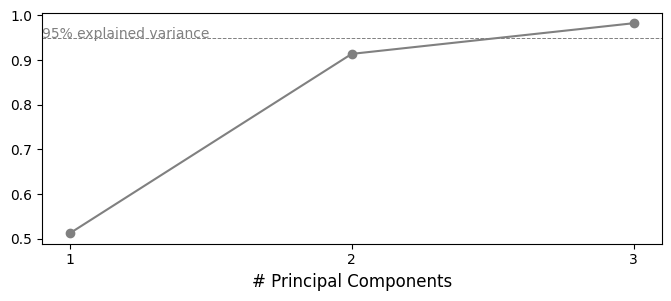

In [78]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 3))
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', color='grey')
plt.axhline(y=0.95, color='grey', linestyle='--', linewidth=0.7)
plt.text(0.9, 0.95, '95% explained variance', color = 'grey', fontsize=10)
plt.xlabel('# Principal Components', fontsize=12)
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.show()

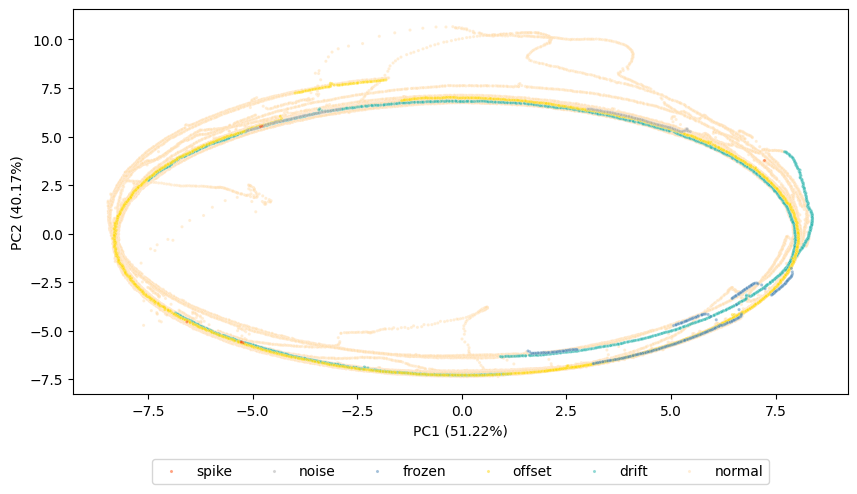

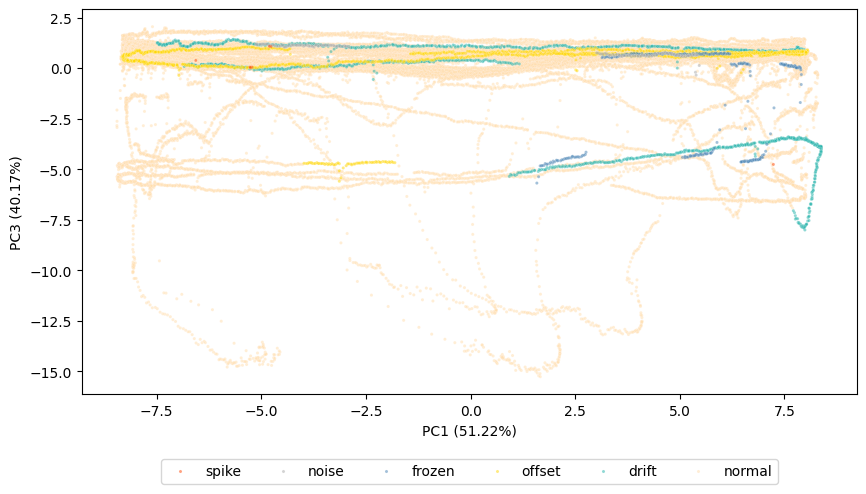

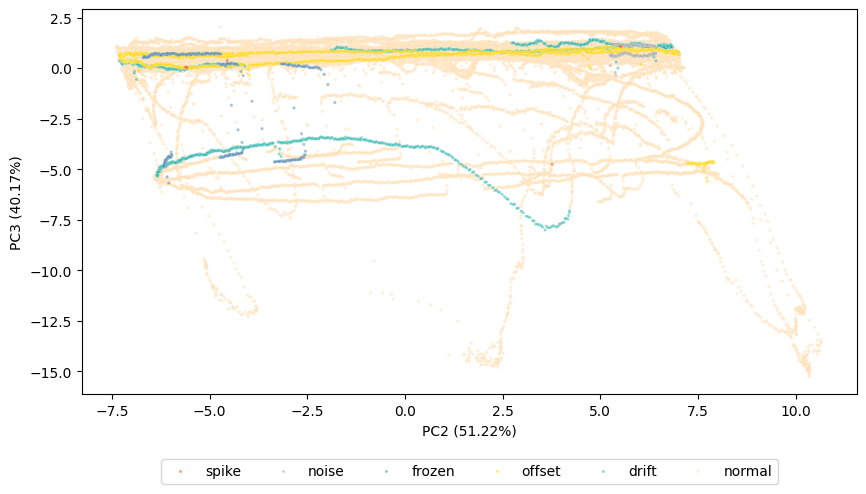

In [79]:
plot_pcs = list(pca_df.columns[list(range(max_components))])
#plot_pcs = ['PC1', 'PC2']
pcs_combs = list(itertools.combinations(plot_pcs, 2))

for x, y in pcs_combs:
    pca_plot(pca_df, x, y, explained_variance, 'Anomaly', hue_map,
             plot_loadings=False, loadings=loadings)

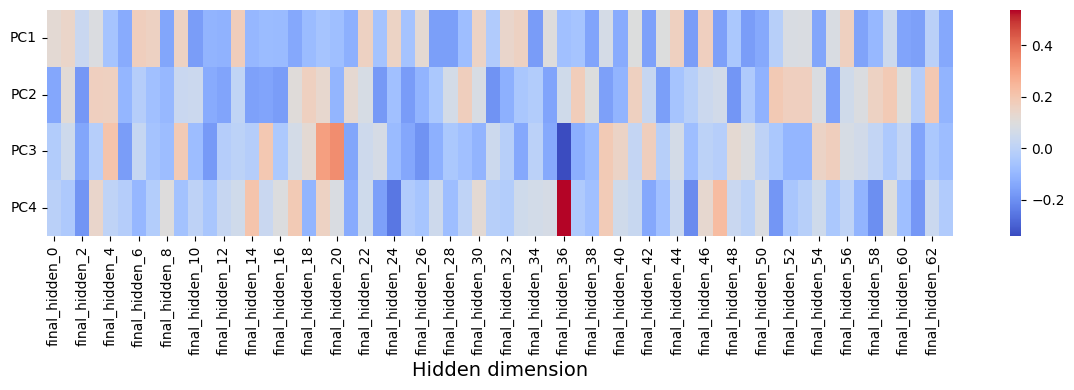

In [69]:
# visualize like the confsion matrix
plt.figure(figsize=(12, 4))
sns.heatmap(loadings.T, annot=False, cbar=True, cmap='coolwarm')
plt.xlabel('Hidden dimension', fontsize=14)
# rotate the y labels
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Anomaly detection on the output

Outliers: 5466


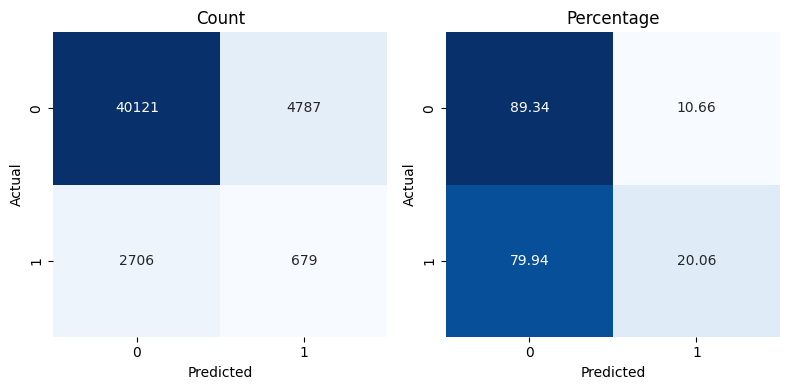

In [81]:
### Isolation Forest
# the contamination is the proportion of outliers in the data
iso_forest = IsolationForest(
    contamination='auto', # 0.0001 
    random_state=config['training_args']['seed']
    ).fit(outputs.iloc[:, use_column_idx])

# predict the outliers
preds = iso_forest.predict(outputs.iloc[:, use_column_idx]) # -1 for outliers, 1 for inliers
# adjust to indicator
preds = [1 if x == -1 else 0 for x in preds]
decision_function = iso_forest.decision_function(outputs.iloc[:, use_column_idx])
print(f"Outliers: {np.sum(preds)}")


# Confusion matrix
conf_matrix = confusion_matrix(1*(outputs['polluted']!=0), preds)
# Normalize the confusion matrix by row (i.e., by actual class) for percentage
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot the raw confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Count')

# Plot the confusion matrix with percentages
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Percentage')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

#### Create a feature dataframe

In [7]:
# Create the feature DataFrame
feature_df = pd.DataFrame()
feature_df['starttime'] = outputs['starttime']
feature_df['valid_index'] = outputs['valid_index']
feature_df['polluted'] = outputs['polluted']

identifier_columns = []

# # Save the target
# feature_df['target'] = outputs['target']
# identifier_columns.append('target')

# Calculate mae
feature_df['mae'] = np.abs(outputs['prediction'] - outputs['target'])
identifier_columns.append('mae')

# Store the mae before and after the anomaly
feature_df['mae_before'] = feature_df['mae'].shift(1)
identifier_columns.append('mae_before')
feature_df['mae_after'] = feature_df['mae'].shift(-1)
identifier_columns.append('mae_after')



### Hidden states

# calculate the cosine similarity between current and next
fh_idxs = column_2_idx['final_hidden']
fh_data = outputs.iloc[:, fh_idxs].to_numpy() # shape: (n_obs, hidden_size)
#fh_data = normalize(fh_data, axis=1)  # Normalize each hidden state vector

# # Calculate cosine similarity between consecutive rows
# cosine_similarities = []
# for i in tqdm(range(len(fh_data) - 1), desc='Calculating cosine similarity'):
#     cosine_sim = cosine_similarity(fh_data[i].reshape(1, -1), fh_data[i + 1].reshape(1, -1))
#     cosine_similarities.append(cosine_sim[0][0])
# # Add the last entry
# feature_df['hidden_cosine'] = np.concatenate([cosine_similarities, [np.nan]])  # Add NaN for the last entry
# identifier_columns.append('hidden_cosine')

sum_abs_diffs = []
for i in tqdm(range(len(fh_data) - 1), desc='Calculating sum of absolute differences'):
    sum_abs_diffs.append(np.sum(np.abs(fh_data[i] - fh_data[i + 1])))
# Add the last entry
feature_df['hidden_abs_diff'] = np.concatenate([sum_abs_diffs, [np.nan]])  # Add NaN for the last entry
identifier_columns.append('hidden_abs_diff')

# Finally, drop nan rows
feature_df = feature_df.dropna()
print(f"Feature DataFrame shape: {feature_df.shape}")
identifier_columns

Calculating sum of absolute differences:   0%|          | 0/48292 [00:00<?, ?it/s]

Calculating sum of absolute differences: 100%|██████████| 48292/48292 [00:00<00:00, 177445.30it/s]

Feature DataFrame shape: (48291, 7)


['mae', 'mae_before', 'mae_after', 'hidden_abs_diff']

In [28]:
# save the feature_df
feature_df.to_csv(outputs_folder / f'{anomaly}_features.csv', index=False)

In [36]:
# load the feature_df
feature_df = pd.read_csv(outputs_folder / f'{anomaly}_features.csv')
feature_df.head(2)  

,starttime,valid_index,polluted,mae,mae_before,mae_after,hidden_abs_diff
0,2018-04-26 05:25:00,121,0.0,0.001812,0.000300,0.000291,0.060420
1,2018-04-26 05:26:00,122,0.0,0.000291,0.001812,0.000283,0.040976


## Identify anomalies

In [37]:
### Isolation Forest
# the contamination is the proportion of outliers in the data
iso_forest = IsolationForest(
    contamination='auto', # 0.0001 
    random_state=config['training_args']['seed']
    ).fit(feature_df[identifier_columns])

# predict the outliers
feature_df['pred_outlier'] = iso_forest.predict(feature_df[identifier_columns])
#feature_df['pred_outlier'] = iso_forest.predict(feature_df[identifier_columns])
# adjust to indicator
feature_df['pred_outlier'] = feature_df['pred_outlier'].apply(lambda x: 1 if x == -1 else 0)
# and get decision function
feature_df['decision_function'] = iso_forest.decision_function(feature_df[identifier_columns])

# classification
feature_df['pred_outlier'].value_counts()

pred_outlier
0    45040
1     3251
Name: count, dtype: int64

# Evaluate

- *Precision*: how many of the predicted anomalies are actual anomalies
- *Recall*: how many of the actual anomalies were predicted
- *Timing*: **accuracy** and **proximity**
    - *Start*
    - *Middle*
    - *End*
- *Anomaly Coverage*: overlap / anomaly length


In [38]:
feature_df['synthetic'] = 1*(feature_df['polluted'] != 0)

In [39]:
# Define a function to categorize each prediction
def label_case(row, target='target', prediction='prediction'):
    if row[target] == 1 and row[prediction] == 1:
        return 'TP'  # True Positive
    elif row[target] == 0 and row[prediction] == 1:
        return 'FP'  # False Positive
    elif row[target] == 0 and row[prediction] == 0:
        return 'TN'  # True Negative
    elif row[target] == 1 and row[prediction] == 0:
        return 'FN'  # False Negative


# Apply the function to the DataFrame
feature_df['Outcome'] = feature_df.apply(lambda row: label_case(row, 'synthetic', 'pred_outlier'), axis=1)


#### Global

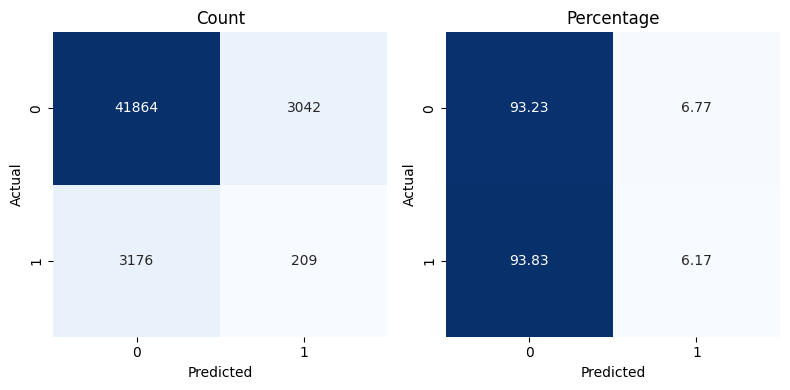

In [40]:

conf_matrix = confusion_matrix(feature_df['synthetic'], feature_df['pred_outlier'])

# Normalize the confusion matrix by row (i.e., by actual class) for percentage
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot the raw confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Count')

# Plot the confusion matrix with percentages
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Percentage')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [41]:
# Precision
precision = precision_score(feature_df['synthetic'], feature_df['pred_outlier'])
print(f"Precision: {precision*100:.2f}%")

# Recall
recall = recall_score(feature_df['synthetic'], feature_df['pred_outlier'])
print(f"Recall: {recall*100:.2f}%")

Precision: 6.43%
Recall: 6.17%


#### Individual

In [42]:
# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(feature_df['synthetic'].to_list()) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

In [43]:
# Find all indices where the value is 1
ones_indices = np.where(feature_df['pred_outlier'] == 1)[0]
# Find the closest index in both directions
if len(ones_indices) == 0:
    # do not continue
    raise ValueError("No anomalies detected")

coverage = []
timing = []

for start, end in anomaly_start_end:
    # extract relevant data
    anomaly_data = feature_df.iloc[start:end+1]
    
    # Coverage
    coverage.append(anomaly_data['pred_outlier'].sum() / len(anomaly_data))

    # Timing
    distances = np.abs(ones_indices - start)
    closest_index = ones_indices[np.argmin(distances)]
    timing.append(closest_index - start)



print(f"Coverage: {np.mean(coverage)*100:.2f}%")
print(f"Timing: {np.mean(timing)} minutes")

Coverage: 15.52%
Timing: 24.333333333333332 minutes


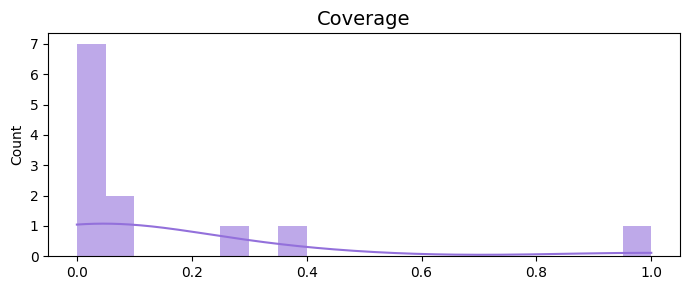

In [44]:
plt.figure(figsize=(7, 3))
sns.histplot(coverage, kde=True, color='mediumpurple', alpha=0.6, linewidth=0, bins=20)
plt.title('Coverage', fontsize=14)
plt.tight_layout()
plt.show()

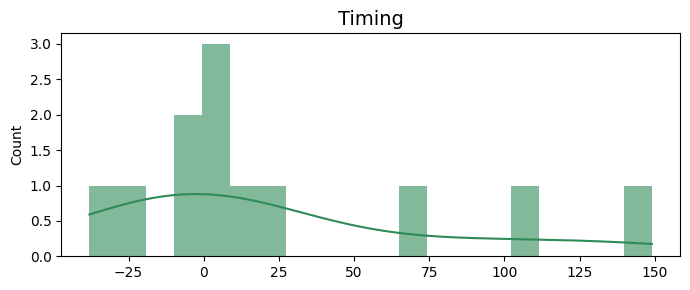

In [45]:
plt.figure(figsize=(7, 3))
sns.histplot(timing, kde=True, color='seagreen', alpha=0.6, linewidth=0, bins=20)
plt.title('Timing', fontsize=14)
plt.tight_layout()
plt.show()

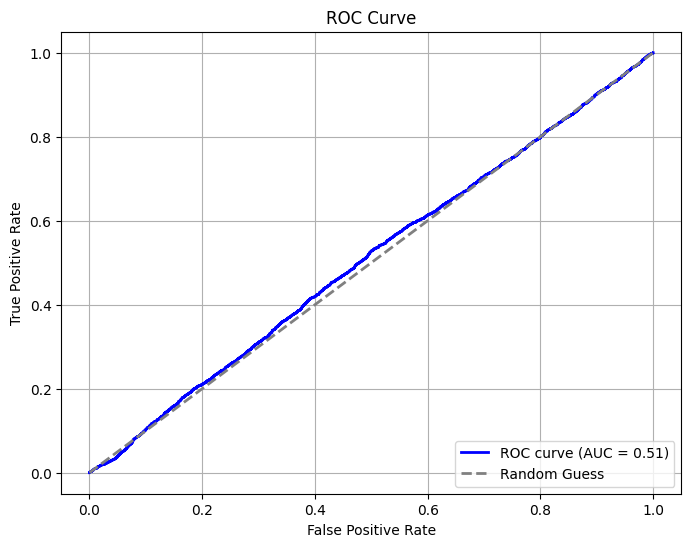

In [46]:

fpr, tpr, thresholds = roc_curve(feature_df['synthetic'], -feature_df['decision_function'])
# Compute AUC score
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Interpret

In [47]:
hue_map = {
    'TP': 'darkblue',  
    'FN': 'firebrick', 
    'FP': 'navajowhite',    
    'TN': 'yellowgreen'   
}
# Desired hue order
hue_order = hue_map.keys()
hue_order = list(hue_order)[::-1]

#### Features

In [48]:
# Create a custom color palette (e.g., 'blue' for Normal and 'red' for Outlier)
palette = {0: 'cornflowerblue', 1: 'indianred'}  # 'Normal' will be blue, 'pred_outlier' will be red
classes = ['Normal', 'pred_outlier']
legend_handles = [Patch(color=palette[key], label=classes[key]) for key in palette.keys()]


In [49]:
# # Create a custom color palette (e.g., 'blue' for Normal and 'red' for Outlier)
# palette = {0: 'cornflowerblue', 1: 'indianred'}  # 'Normal' will be blue, 'pred_outlier' will be red
# classes = ['Normal', 'pred_outlier']
# legend_handles = [Patch(color=palette[key], label=classes[key]) for key in palette.keys()]

# for col in feature_df[identifier_columns].select_dtypes(include='number').columns:
#     plt.figure(figsize=(7, 3))

#     # Plot using 'pred_outlier' as hue with the custom palette
#     sns.histplot(data=feature_df,
#         x=col, hue='pred_outlier', kde=True, 
#         palette=palette, alpha=0.6, hue_order=[0, 1],
#         linewidth=0,  
#         bins=50,
#         )
    
#     plt.legend(legend_handles, classes, title='Class', loc='upper right') 

#     plt.title(f"{col.capitalize()}", fontsize=14)
#     plt.xlabel(f"")   
#     plt.tight_layout()
#     plt.show()


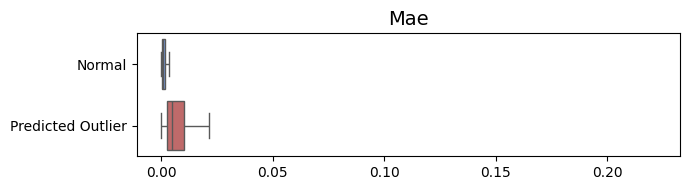

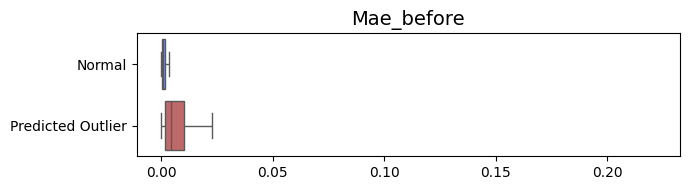

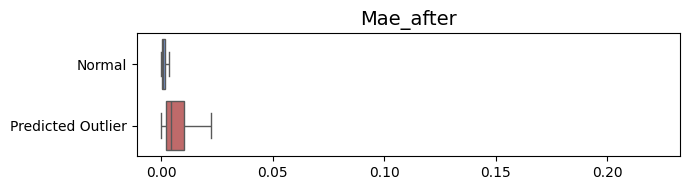

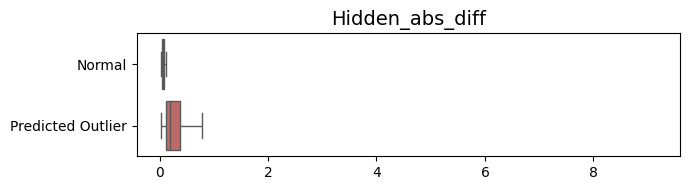

In [52]:
palette.update({str(k): v for k, v in palette.items()})

for col in identifier_columns:
    plt.figure(figsize=(7, 2))
    sns.boxplot(
        data=feature_df, x=col, y='pred_outlier', orient='h',
        palette=palette, fliersize=0, linewidth=1, hue_order=[0, 1],
    )
    plt.title(col.capitalize(), fontsize=14)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0, 1], ['Normal', 'Predicted Outlier'])
    plt.tight_layout()
    plt.show()

#### PCA

In [53]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(feature_df[identifier_columns])

# Apply PCA
n_components = min(3, len(identifier_columns))
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_scaled)

# DataFrame with the PCA components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
# add the outcome
pca_df['Outcome'] = feature_df['Outcome'].values

# Get the loadings (components)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to match feature-column structure
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],  
    index=feature_df[identifier_columns].columns  
)

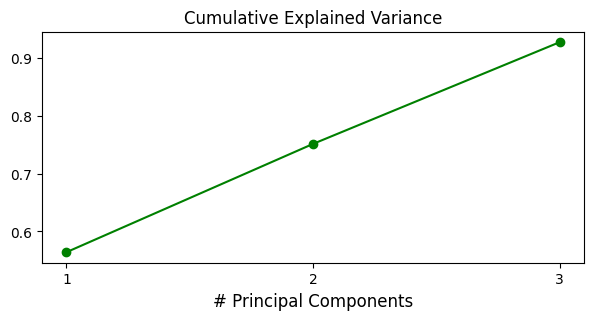

In [54]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(7, 3))
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', color='green')
plt.title('Cumulative Explained Variance')
plt.xlabel('# Principal Components', fontsize=12)
plt.xticks(np.arange(1, len(explained_variance) + 1))
#plt.grid(True)
plt.show()

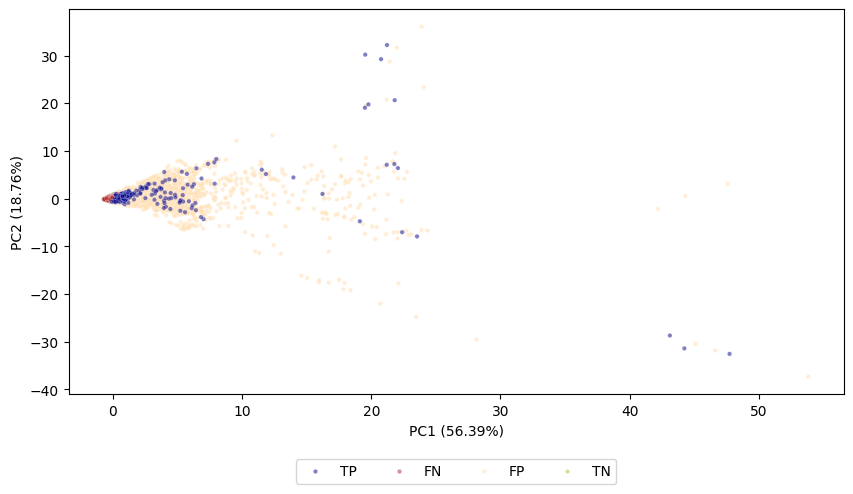

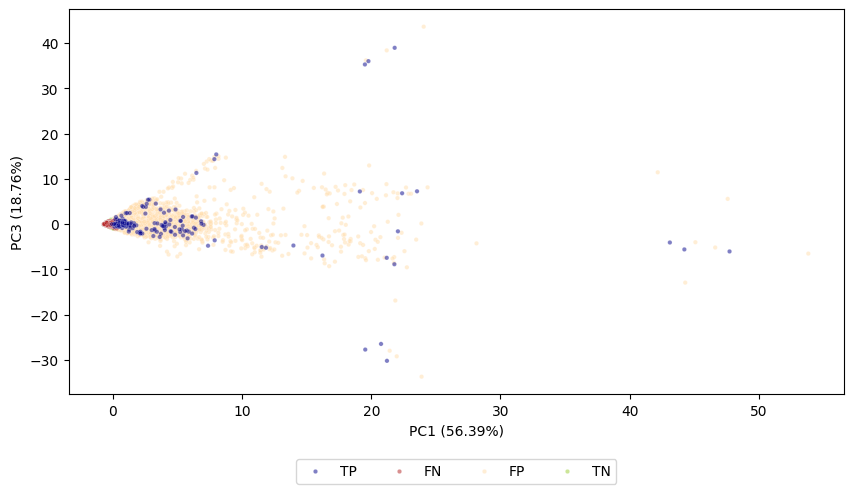

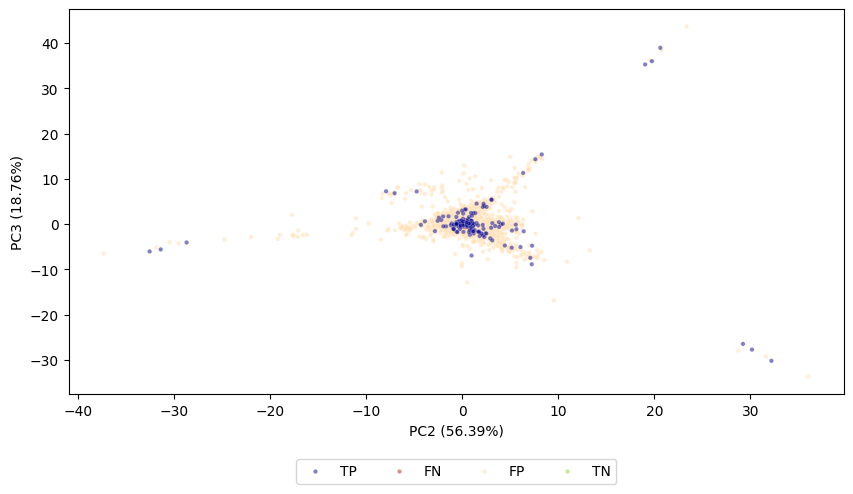

In [56]:
plot_pcs = ['PC1', 'PC2', 'PC3']
possible_pcs = [col for col in pca_df.columns if 'PC' in col]
plot_pcs = [pc for pc in plot_pcs if pc in possible_pcs]
plot_pcs = list(itertools.combinations(plot_pcs, 2))

for x, y in plot_pcs:
    pca_plot(pca_df, x, y, explained_variance, 'Outcome', hue_map)

TODO: visualize some examples?
e.g.
- 2 with higher detection score, 
- and 2 that are true anomalies, 
    - classified, and not classified

#### Scatter plot

In [57]:
identifier_columns

['mae', 'mae_before', 'mae_after', 'hidden_abs_diff']

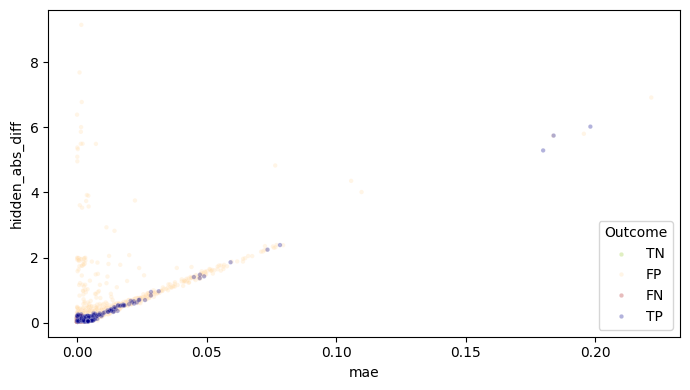

In [59]:
# visualize the mae and the hidden_cosine, colored by the outcome
plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=feature_df.sort_values('Outcome', key=np.vectorize(hue_order.index)),
    x='mae', y='hidden_abs_diff', hue='Outcome', 
    hue_order=hue_order,
    palette=hue_map, alpha=0.3, s=10)
plt.title('', fontsize=14)
plt.tight_layout()
plt.show()

## Visualization of the features

#### Feature dataframe

In [60]:
identifier_columns

['mae', 'mae_before', 'mae_after', 'hidden_abs_diff']

In [61]:
# import 

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)  # 2D visualization
X_tsne = tsne.fit_transform(feature_df[identifier_columns])

# Store t-SNE results
tsne_df = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
del X_tsne

In [62]:
tsne_df['Outcome'] = feature_df['Outcome'].values

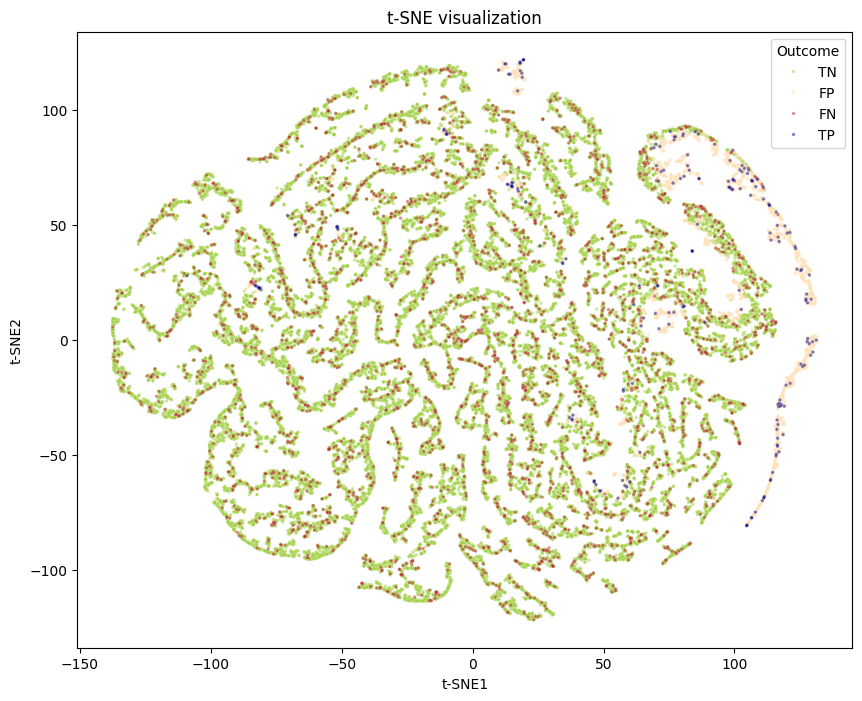

In [63]:
# Visualize the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', 
                data=tsne_df.sort_values('Outcome', key=np.vectorize(hue_order.index)),
                hue='Outcome', 
                hue_order=hue_order,
                palette=hue_map, s=6, alpha=0.5)
plt.title('t-SNE visualization')
plt.show()

## Visualization on the output

In [96]:
column_2_idx.keys()

dict_keys(['starttime', 'valid_index', 'polluted', 'target', 'prediction', 'final_hidden'])

In [97]:
use_columns = ['final_hidden']
col_idxs = []
for col_type, col_idx in column_2_idx.items():
    if col_type in use_columns:
        col_idxs.extend(col_idx)

#### PCA

In [99]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(outputs.iloc[:, col_idxs])

# Apply PCA
n_components = min(5, len(col_idxs))
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_scaled)

# DataFrame with the PCA components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
# add the outcome
pca_df['polluted'] = outputs['polluted'].values


In [64]:
# import 

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)  # 2D visualization
X_tsne = tsne.fit_transform(outputs.iloc[:, column_2_idx['final_hidden']])

# Store t-SNE results
tsne_df = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['polluted'] = outputs['polluted'].values
del X_tsne

In [84]:
indicator_2_data = {v: k for k, v in anomaly_2_indicator.items()}
indicator_2_data[0] = 'normal'
indicator_2_data

{1: 'spike', 2: 'noise', 3: 'frozen', 4: 'offset', 5: 'drift', 0: 'normal'}

In [85]:
hue_map = {
    0: 'navajowhite',  
    1: 'OrangeRed',
    2: 'DarkGray',
    3: 'SteelBlue',
    4: 'Gold',
    5: 'LightSeaGreen',
}
hue_order = list(hue_map.keys())
hue_order

[0, 1, 2, 3, 4, 5]

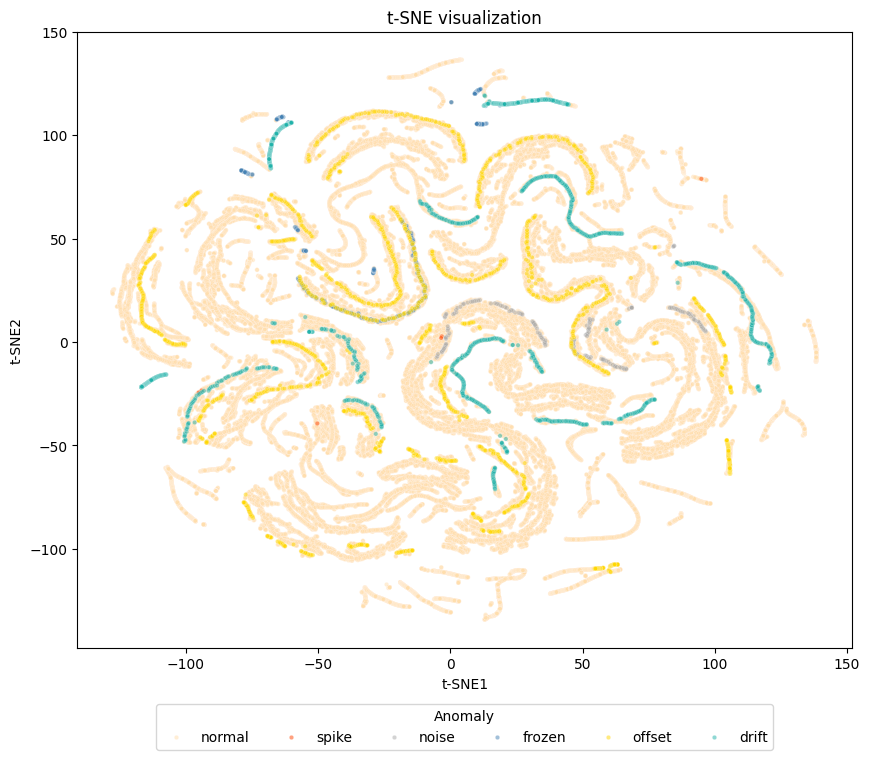

In [89]:
# Visualize the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', 
                data=tsne_df.sort_values('polluted', key=np.vectorize(hue_order.index)),
                hue='polluted', hue_order=hue_order,
                palette=hue_map, s=10, alpha=0.5)

# Create a custom legend for indicator_2_anomaly
handles, labels = plt.gca().get_legend_handles_labels()
# Add the anomaly legend
plt.legend(handles, [indicator_2_data[int(label)] for label in labels], 
           title='Anomaly', loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=len(hue_map))
plt.title('t-SNE visualization')
plt.show()